# Deep Painterly Harmonization

A PyTorch implementation of the [Deep Painterly Harmonization](https://arxiv.org/abs/1804.03189) paper by  Fujun Luan, et al.

The authors of the paper published their code based on torch [here](https://github.com/luanfujun/deep-painterly-harmonization). My PyTorch implementation is inspired by it.

## Initial setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Import libraries.

In [2]:
from fastai.conv_learner import *

## Download dataset

You can download the data [here](https://github.com/luanfujun/deep-painterly-harmonization/tree/master/data).

Setup directories and files path.

 Make the `PATH` variable point to the download data.

In [10]:
PATH = Path('../../../data/wikiart')

We will focus on this example of painting for this notebook:

![Captain America](https://raw.githubusercontent.com/luanfujun/deep-painterly-harmonization/master/data/16_target.jpg)

## Data pipeline

Each example has 4 images associated to it:
- the style image (which is the painting)
- the input (our object superimposed on the painting)
- the mask that allows us to know where we added the object
- the dilated version of the mask

In [16]:
index = 16

style_img = open_image(PATH / f'{index}_target.jpg')
input_img = open_image(PATH / f'{index}_naive.jpg')
mask = open_image(PATH / f'{index}_c_mask.jpg')
dilated_mask = open_image(PATH / f'{index}_c_mask_dilated.jpg')

Plot and show images.

(-0.5, 699.5, 556.5, -0.5)

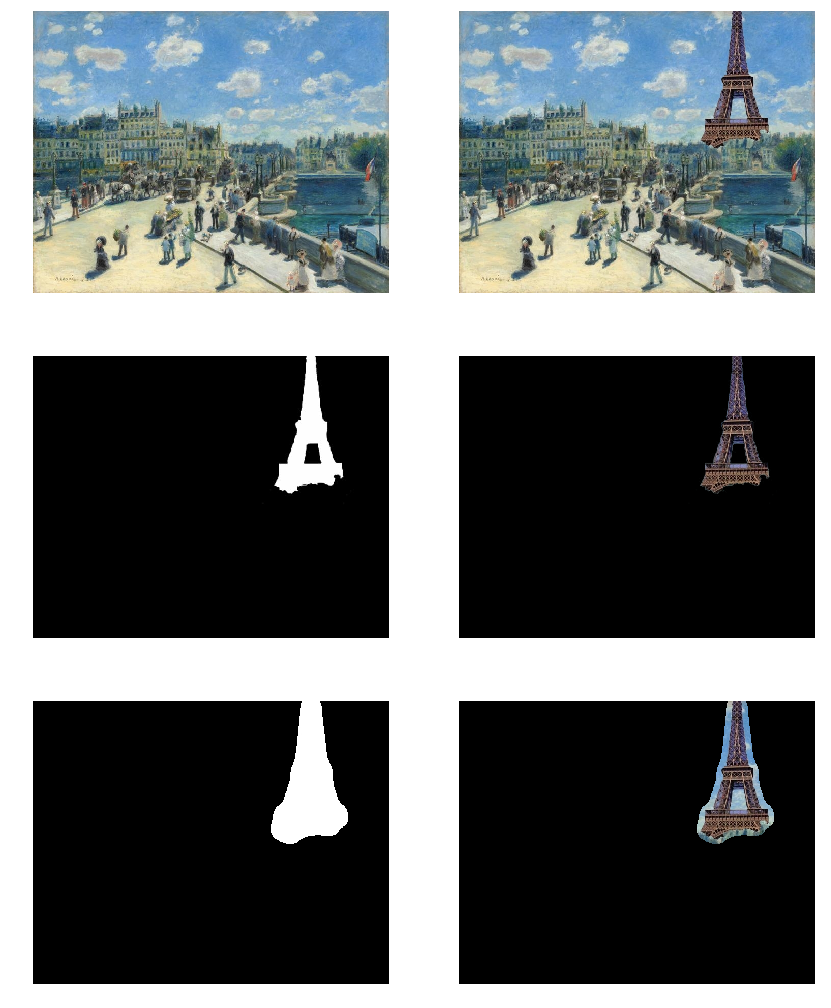

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(14, 18))

ax[0][0].imshow(style_img)
ax[0][0].axis('off')

ax[0][1].imshow(input_img)
ax[0][1].axis('off')

ax[1][0].imshow(mask)
ax[1][0].axis('off')

ax[1][1].imshow(input_img * mask)
ax[1][1].axis('off')

ax[2][0].imshow(dilated_mask)
ax[2][0].axis('off')

ax[2][1].imshow(input_img * dilated_mask)
ax[2][1].axis('off')

Create a slightly enlarged version of our normal mask.

In [63]:
enlarge_mask = cv2.GaussianBlur(mask, (3, 3), 1)

Prepare our images ready for the model.

In [80]:
# Normalize the input and style image for VGG16 model.
trn_tfms, val_tfms = tfms_from_model(vgg16, 500, crop_type=CropType.NO)

In [81]:
print(val_tfms.tfms)

# Keep the image at their specific size. So, removes the scale transform.
val_tfms.tfms = val_tfms.tfms[2:]
val_tfms

[<fastai.transforms.Scale object at 0x7f43e56eaeb8>, <fastai.transforms.NoCrop object at 0x7f43e5642d30>, <fastai.transforms.Normalize object at 0x7f43e56ea3c8>, <fastai.transforms.ChannelOrder object at 0x7f43e5642c50>]


[<fastai.transforms.Normalize object at 0x7f43e56ea3c8>, <fastai.transforms.ChannelOrder object at 0x7f43e5642c50>]

In [82]:
# Transformed style image
style_tfm = val_tfms(style_img)

# Transformed input image
input_tfm = val_tfms(input_img)

## Model

We will use VGG16 network architecture.

We employed pre-trained VGG-16 as the feature extractor.

In the two steps of the algorithm, we will only use the VGG activations of layer 36, so I've freezed the layers we don't use by setting it to not trainable so we don't waste time and memory calculating gradients for it.

In [83]:
layers = cut_model(vgg16(True), 37)
vgg_model = to_gpu(nn.Sequential(*layers)).eval()
set_trainable(vgg_model, False)

In [85]:
vgg_model = to_gpu(vgg16(True)).eval()
set_trainable(vgg_model, False)

In [86]:
vgg_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

We will use the activations of `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1` and `conv5_1` during the two steps of the process. The layer indexes are 2, 9, 16, 26 and 36.

## First Pass: Robust Coarse Harmonization

From the paper, for the first-pass optimization, they chose `conv4_1` as the content representation, and `conv3_1`, `conv4_1` and `conv5_1` as the style representation, since higher layers have been transformed by the CNN into representations with more of the actual content, which is crucial for the semantic-aware nearest-neighbor search.

In [87]:
index_layers = [16, 26, 36]

So rather than lopping off all of the layers after the one we want, it be nice if we could somehow grab the activations of a few layers as it calculates. PyTorch has these fantastic things called **hooks**. You can have forward hooks that let you plug anything you like into the forward pass of a calculation or a backward hook that lets you plug anything you like into the backward pass.

In [91]:
class SaveFeatures(nn.Module):
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()

We hook those chosen layers so every time we do a forward pass on the VGG model, it's going to store the 16th, 26th and 36th layer's output (activations) inside `sf.features`.

In [93]:
save_features = [SaveFeatures(children(vgg_model)[index]) for index in index_layers]

Get the features for our input image and our style image.

In [97]:
# None is to add a batch dimension.
# VV is a util function that returns PyTorch Variable without require_grad.
inp_tfm_var = VV(input_tfm[None])
vgg_model(inp_tfm_var)
input_features = [s.features for s in save_features]
[ifs.shape for ifs in input_features]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

In [98]:
style_tfm_var = VV(style_tfm[None])
vgg_model(style_tfm_var)
style_features = [s.features for s in save_features]
[sfs.shape for sfs in style_features]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

Next, we make a pass with our mask to get its corresponding features.

The authors half the mask dimension at each max pooling, then pass it through a `nn.AvgPool2d(3, 1, 1)` (3 by 3, stride 1, padding 1 average pooling) at each convolutional layer.

In [99]:
ConvMask = nn.AvgPool2d(3, 1, 1)

def conv(mask, n):
    x = V(mask[None][None])

    for i in range(n):
        x = ConvMask(x)

    return to_np(x.data.squeeze())

In [100]:
def resize_half(mask):
    h, w = mask.shape
    return cv2.resize(mask, (w//2, h//2))

In [101]:
def get_mask_features(mask):
    features = []

    mask = resize_half(conv(mask, 2))
    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)

    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)

    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)

    return features

In [102]:
mask_features = get_mask_features(dilated_mask[:, :, 0])
[mfs.shape for mfs in mask_features]

[(139, 175), (69, 87), (34, 43)]

### Mapping

The first pass is based on Leon Gatys's neural style transfer idea.

We are going to map every pixel of the content features to one in the style features.

In [105]:
def arr2vec(x, kernel_size=3, stride=1, padding=1):
    """
    A vectorization function to get all the possible patches in a big array.
    """
    ch, n1, n2 = x.shape
    y = np.zeros((ch, n1+2*padding, n2+2*padding))
    y[:, padding:n1+padding, padding:n2+padding] = x
    start_index = np.array([j + (n2+2*padding)*i
                            for i in range(0, n1-kernel_size+1+2*padding, stride)
                                for j in range(0, n2-kernel_size+1+2*padding, stride)])
    grid = np.array([j + (n2+2*padding)*i + (n1+2*padding) * (n2+2*padding) * k
                     for k in range(0, ch)
                         for i in range(kernel_size)
                             for j in range(kernel_size)])
    to_take = start_index[:, None] + grid[None, :]
    return y.take(to_take)

Compute the cosine similarities and get the mapping.

In [109]:
def map_features(input_feats, style_feats):
    mapping = []

    for inp, sty in zip(input_feats, style_feats):
        inp_var = VV(arr2vec(to_np(inp[0].data)))
        sty_var = VV(arr2vec(to_np(sty[0].data)))
        scalars = torch.mm(inp_var, sty_var.t())
        norms_inp = torch.sqrt((inp_var ** 2).sum(1))
        norms_sty = torch.sqrt((sty_var ** 2).sum(1))
        cosine_sim = scalars / (1e-15 + norms_inp.unsqueeze(1) * norms_sty.unsqueeze(0))
        _, index_max = cosine_sim.max(1)
        mapping.append(to_np(index_max))

    return mapping

In [110]:
mappings = map_features(input_features, style_features)

Then we use this mappings to re-map the style features.

In [119]:
def remap_style(style_feats, mp):
    out = []
    for sty, maps in zip(style_feats, mp):
        sty = to_np(sty).reshape(sty.size(1), -1)
        sty = sty[:, maps]
        out.append(VV(sty))
    return out

In [120]:
remap_style_features = remap_style(style_features, mappings)

### Reconstruction

In our case, we are not optimizing weights, we are optimizing pixels.

We will optimize the pixels in our input image (the one with object superimposed on the painting).

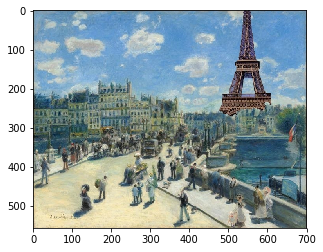

In [113]:
# input_tfm is our VGG16 normalized input image
optimize_img = input_tfm.copy()

# Denormalize image so that we can show it
plt.imshow(val_tfms.denorm(to_np(optimize_img).transpose(1, 2, 0)))

In [114]:
optimize_img_var = V(optimize_img[None], requires_grad=True)
optimize_img_var.shape

torch.Size([1, 3, 557, 700])

Optimizer and step function for the training:

In [116]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([optimize_img_var], lr=1)

In [133]:
def step(loss_fn):
    global n_iter

    optimizer.zero_grad()
    loss = loss_fn(optimize_img_var)
    loss.backward()
    n_iter += 1

    if n_iter % show_iter == 0:
        print(f'Iteration: {n_iter}, loss: {loss.data[0]}')

    return loss

Loss functions

Content loss is the MSE loss of the content and input features from the fourth convolutional layers (stored at index 1). We apply the corresponding mask to both of them before taking this loss.

In [127]:
def content_loss(out_feats):
    out_mask_feats = out_feats * V(mask_features[1][None,None], requires_grad=False)
    in_mask_feats = input_features[1] * V(mask_features[1][None,None], requires_grad=False)
    return F.mse_loss(out_mask_feats, in_mask_feats, size_average=False) / float(out_feats.size(1) * mask_features[1].sum())

For the style loss, we compute the gram matrix and the MSE loss of two gram matrices.

In [128]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target):
    return F.mse_loss(gram(input), gram(target))

Then we apply the mask before taking this loss, for all the layers (conv 3, 4 and 5), with the input features and the remapped style features.

In [140]:
def style_loss(out_feats):
    loss = 0

    for outf, mapstyf, maskf in zip(out_feats, remap_style_features, mask_features):
        inp_gram_mx = outf * V(maskf[None, None], requires_grad=False)
        inp_gram_mx = inp_gram_mx.view(inp_gram_mx.size(1), -1)
        mapsty_gram_mx = mapstyf * V(maskf, requires_grad=False).view(1, -1)
        loss += gram_mse_loss(inp_gram_mx, mapsty_gram_mx)

    return loss / 3

The weights for stage 1.

In [130]:
wgt_cnt, wgt_sty = 1, 10

In [136]:
def stage1_loss(opt_img_var):
    vgg_model(opt_img_var)
    out_feats = [o.features for o in save_features]
    cnt_loss = content_loss(out_feats[1])
    sty_loss = style_loss(out_feats)

    return wgt_cnt * cnt_loss + wgt_sty * sty_loss

### Training

In [141]:
n_iter = 0

while n_iter <= max_iter:
    optimizer.step(partial(step, stage1_loss))

Iteration: 100, loss: 1.0574499368667603
Iteration: 200, loss: 0.6704603433609009
Iteration: 300, loss: 0.5368689298629761
Iteration: 400, loss: 0.47422587871551514
Iteration: 500, loss: 0.43755385279655457
Iteration: 600, loss: 0.4115983247756958
Iteration: 700, loss: 0.39384791254997253
Iteration: 800, loss: 0.3807651102542877
Iteration: 900, loss: 0.3704095184803009
Iteration: 1000, loss: 0.362394779920578


Results.

(-0.5, 699.5, 556.5, -0.5)

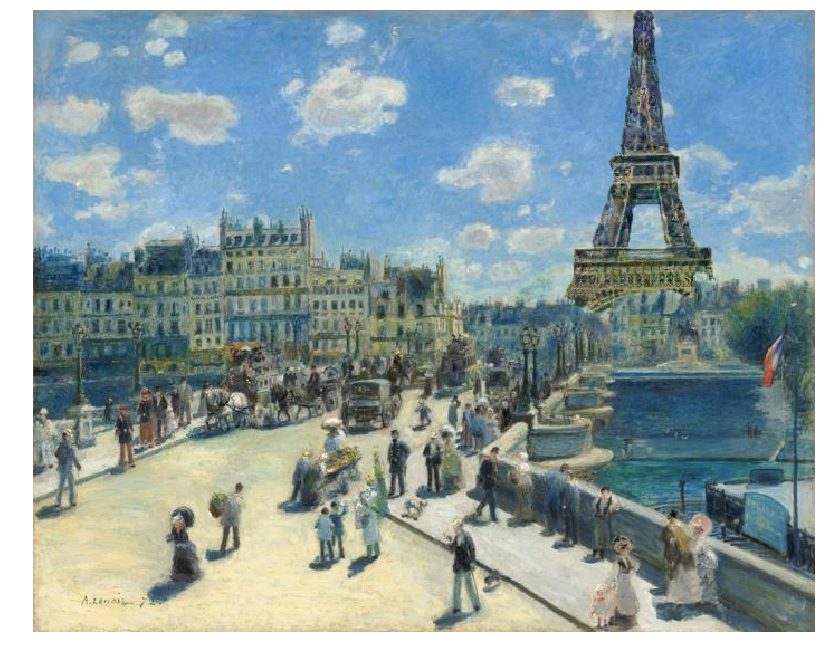

In [144]:
fig, ax = plt.subplots(1,1, figsize=(14, 14))
output_img = val_tfms.denorm(to_np(optimize_img_var.data)[0].transpose(1, 2, 0))
output_img = output_img * enlarge_mask + style_img * (1 - enlarge_mask)
output_img = output_img.clip(0, 1)
ax.imshow(output_img)
ax.axis('off')

Save our work for the second stage.

In [148]:
np.save(PATH / f'stage_1_painting{index}.npy', output_img)

## Second Pass: High-Quality Refinement